Code for making the plot for the Data Visualisation Society's 'Visualize the membership - 1 year' challenge.

Data was obtained from: https://www.datavisualizationsociety.com/visualize-the-membership-1-year

Created March 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.spatial as sp
import networkx as nx
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def lat_lon_to_xyz(lat,lon) :
    """
    Convert lat/lon coordinates
    to positions in 3D space
    """
    R_E = np.float64(6378.0) #Radius of Earth in km.
    lat_rad=np.radians(lat)
    lon_rad=np.radians(lon)
    x=R_E*math.sin(math.pi/2.0-lat_rad)*math.cos(lon_rad)
    y=R_E*math.sin(math.pi/2.0-lat_rad)*math.sin(lon_rad)
    z=R_E*math.cos(math.pi/2.0-lat_rad)
    return (x,y,z)

# Read in an clean Nan's

In [3]:
df=pd.read_csv("data/dvs_challenge_3_membership_anniversary.csv")
print(len(df))
df=df.dropna()
print(len(df))

11573
11317


# Extract the unique coordinates

In [4]:
x_coords = list(df['long'])
y_coords = list(df['lat'])

coordinates = [ tuple(p) for p in np.transpose([y_coords,x_coords]) ]
print(f"Thre are {len(coordinates)} loctions recorded")

coordinate_set=list(set(coordinates))
print(f"Unique locations = {len(coordinate_set)}")

#Convert to 3d:
Coord_set_3d = [ lat_lon_to_xyz(i[0],i[1]) for i in coordinate_set ]

Thre are 11317 loctions recorded
Unique locations = 2120


In [5]:
def get_closest_non_visited_node(Visited_Set,Coord_set_3d) :
    """
    Get the closest point wich has not
    previously been visited.
    
    Parameters
    -------------
    
    Visited_Set : list 
    
    List of the indices of points which
    have been previously visited
    
    Coord_set_3d : list
    
    List containing the positions of the
    points.
    
    Returns
    ---------------
    
    closest_non_visited_node : int
    
    Index of the closest point not in the visited set
    
    hop_dist : float
    
    Distance to the closest point which has not previously been
    visited.
    
    """
    tree = sp.cKDTree(Coord_set_3d)
    for k in range(2,len(Coord_set_3d)) : #In each case look at the k-closest distances.
        distances ,  indices = tree.query( Coord_set_3d[Visited_Set[-1]], k )
        Non_visits = list(set(indices)-set(Visited_Set))
        Non_vis_len=len(Non_visits)
        if Non_vis_len >= 1 :
            closest_non_visited_node=Non_visits[0]
            hop_dist=distances[ list(indices).index(closest_non_visited_node) ]
            break
        elif k==len(Coord_set_3d)-1:
            print("Visited all nodes")
            closest_non_visited_node=Visited_Set[-1]
            hop_dist=0.0
        else : #If the closest k points have been visited then we need to increase the index.
            k=k+1
            
    return closest_non_visited_node,hop_dist

In [6]:
Visited_Set=[0] #Initiaze set of visited nodes.
hop_dists=[]

travel_graph=nx.Graph()
order={}

for t in tqdm( range(len(Coord_set_3d)) ) :
    
    order[Visited_Set[-1]]=len(Visited_Set)
    closest_non_visited_node,hop_dist=get_closest_non_visited_node(Visited_Set,Coord_set_3d)
    Visited_Set.append(closest_non_visited_node)
    travel_graph.add_edge(Visited_Set[-1],Visited_Set[-2])
    hop_dists.append( hop_dist )

Visited all nodes



<IPython.core.display.Javascript object>


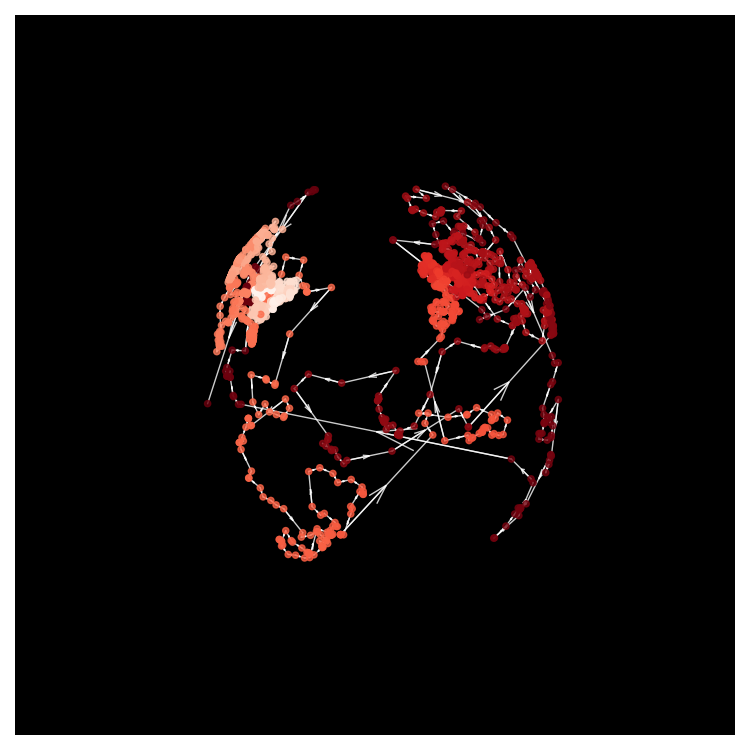

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(7.5,7.5))
ax = fig.add_subplot(111, projection='3d')

x=np.transpose(Coord_set_3d)[0]
y=np.transpose(Coord_set_3d)[1]
z=np.transpose(Coord_set_3d)[2]

colour=[]
for k in range(len(x)) :
    colour.append(order[k])


ax.set_facecolor('black')
ax.scatter(x, y, z, c=colour,marker='o',cmap='Reds',s=20.0,alpha=0.8)
for edge in tqdm( list(travel_graph.edges() ) ) :
    x_vals =[ x[edge[0]],x[edge[1]]]
    y_vals =[ y[edge[0]], y[edge[1]] ]
    z_vals= [ z[edge[0]], z[edge[1]] ]
    ax.plot3D(x_vals,y_vals,z_vals,linewidth=1.0,color='w',alpha=0.8)
    
    
    #Adapted from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
    ax.quiver(x[edge[0]], y[edge[0]], z[edge[0]], # <-- starting point of vector
        (x[edge[1]] - x[edge[0]])/2.0, (y[edge[1]] - y[edge[0]])/2.0, (z[edge[1]] - z[edge[0]])/2.0, # <-- directions of vector
        color = 'w', alpha = .8, lw = 1.0,
    )

plt.axis('off')
plt.tight_layout()
plt.savefig("Around_The_World",dpi=100)

# Plot the distance travelled

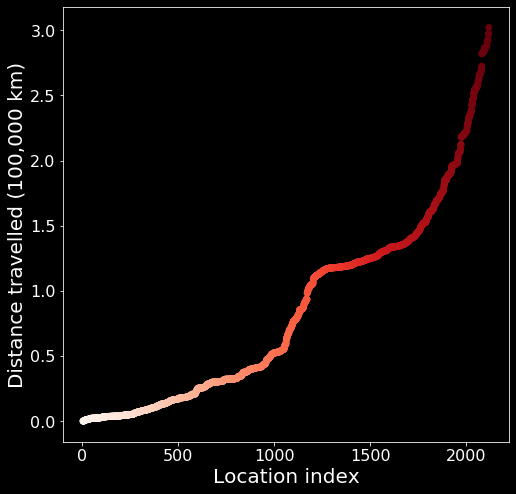

In [8]:
%matplotlib inline
plt.style.use('dark_background')
fig,ax=plt.subplots(figsize=(8,8))
dists_in_100_km = [ i/(100000.0) for i in hop_dists ] 
ax.scatter(np.arange(3,len(dists_in_100_km)), np.cumsum(dists_in_100_km[2:-1]),c=np.arange(3,len(dists_in_100_km)),cmap='Reds')
plt.xlabel("Location index",fontsize=20)
plt.ylabel("Distance travelled (100,000 km)",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("Cumulative distance")

# Loop to make plots for animated gif

To make a gif on the Ubunutu command line:
1.  Navigate the the directory containing the files.
2. Run the command: convert -delay 5 -loop 0 *.png mygif.gif

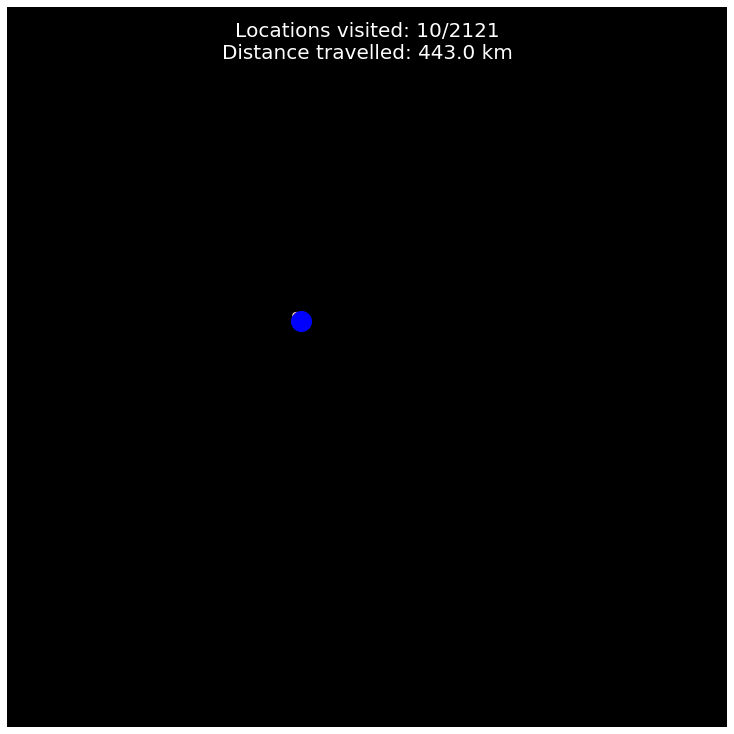

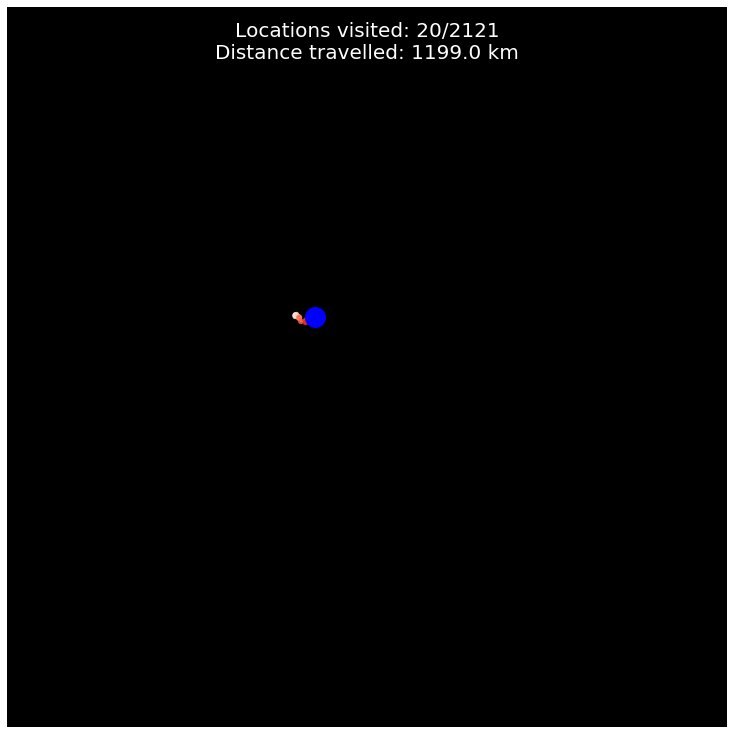

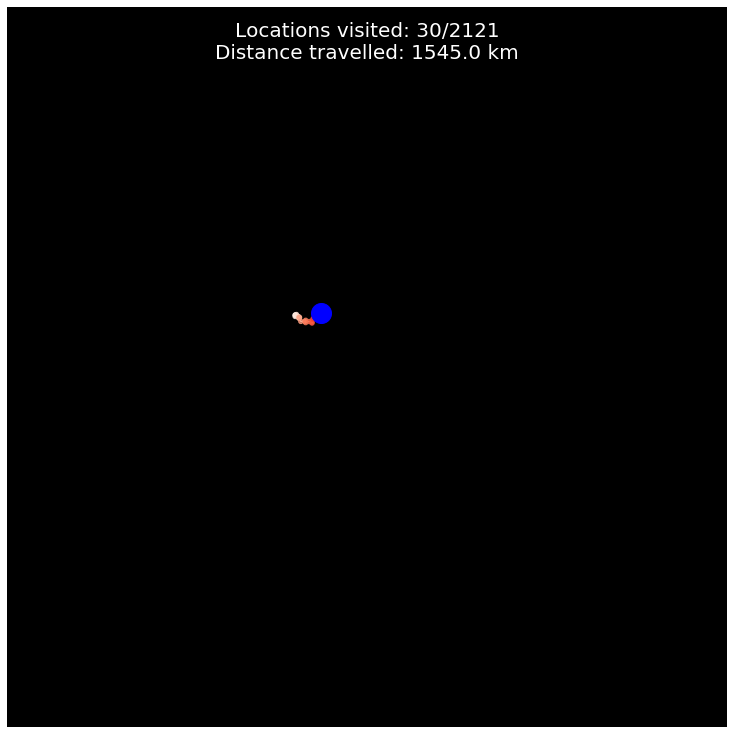

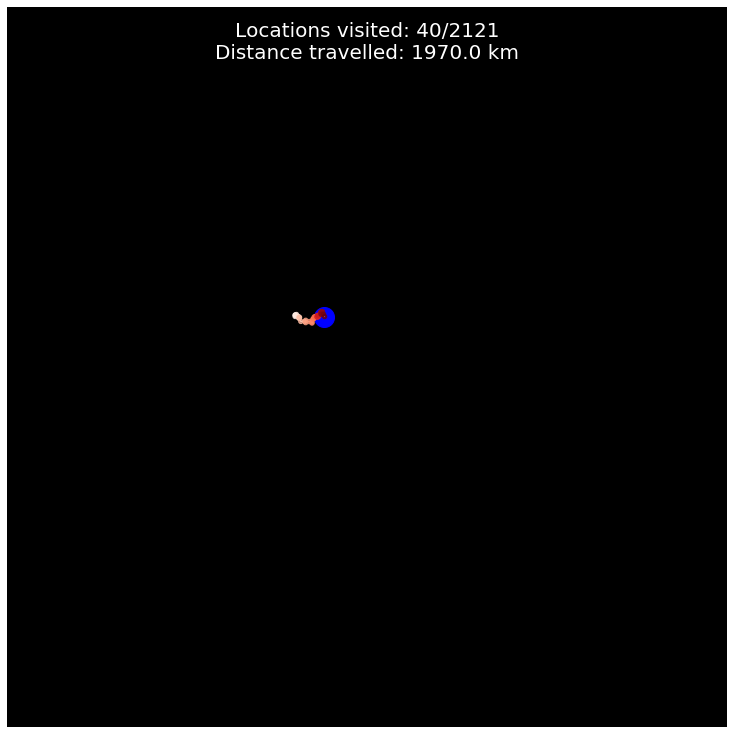

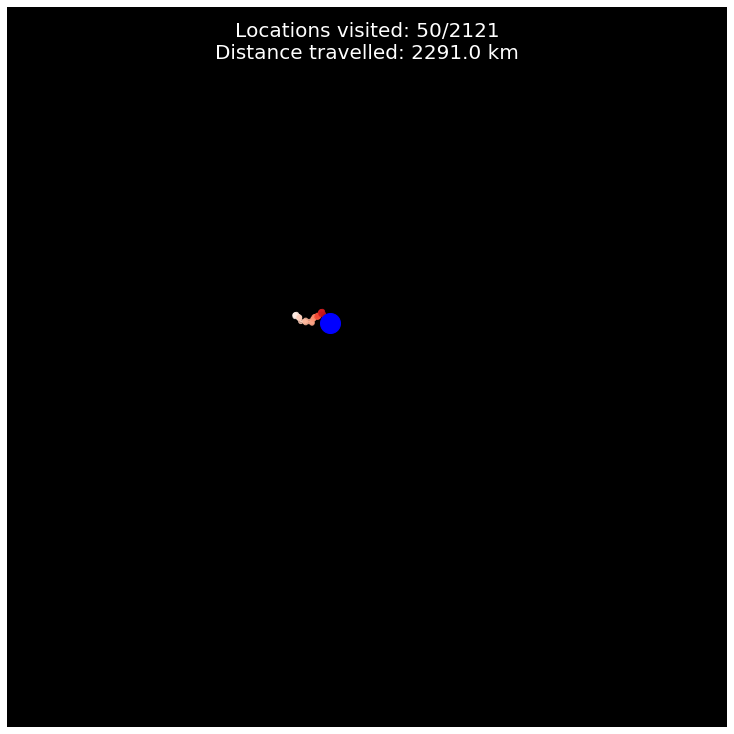

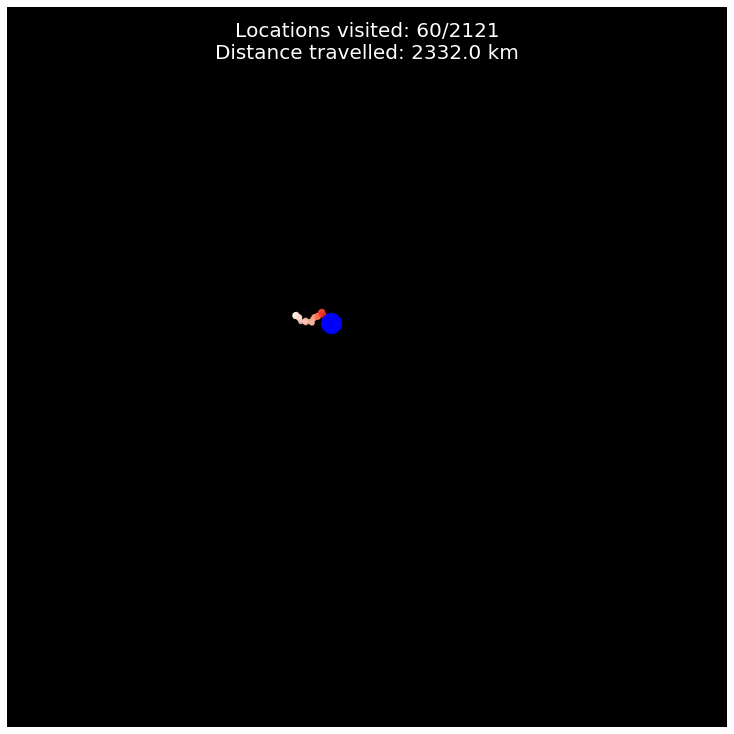

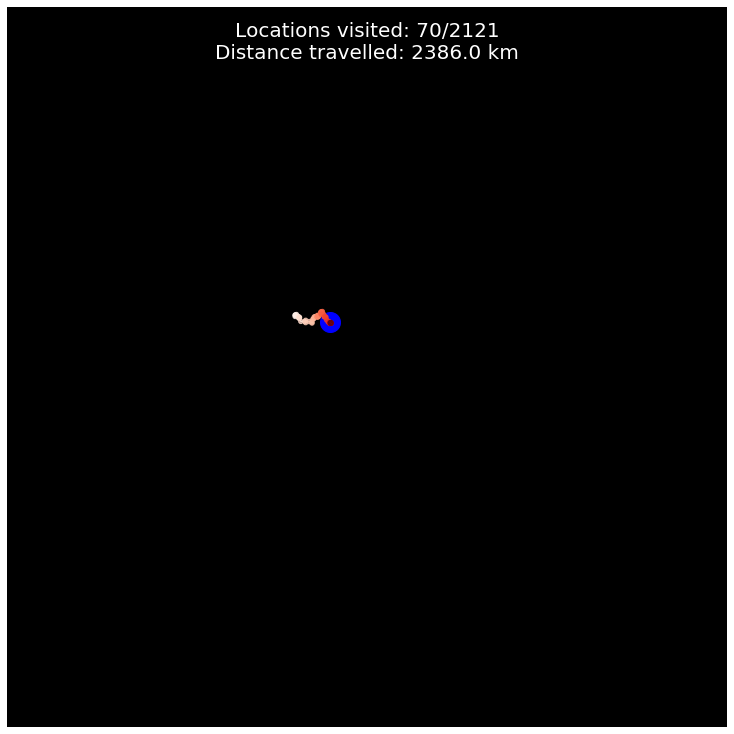

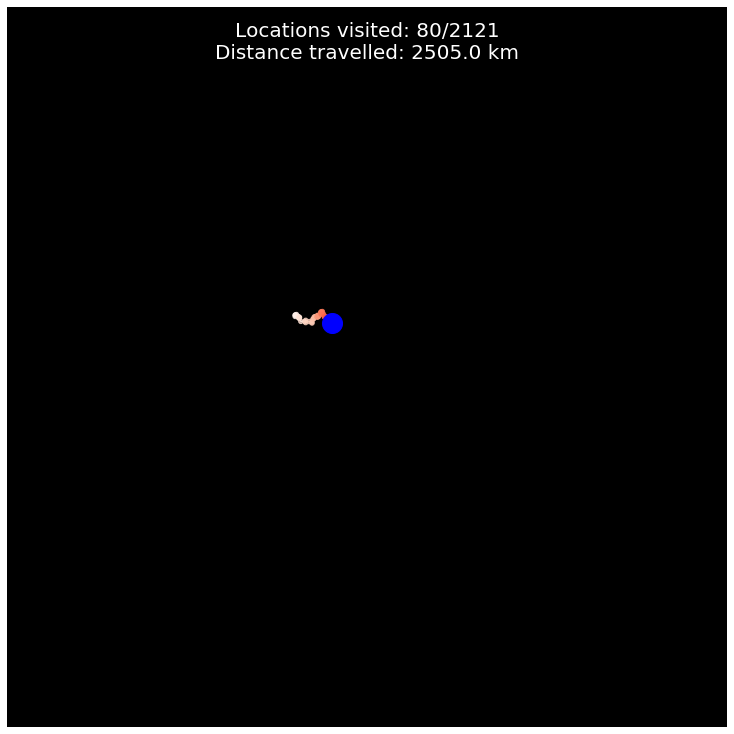

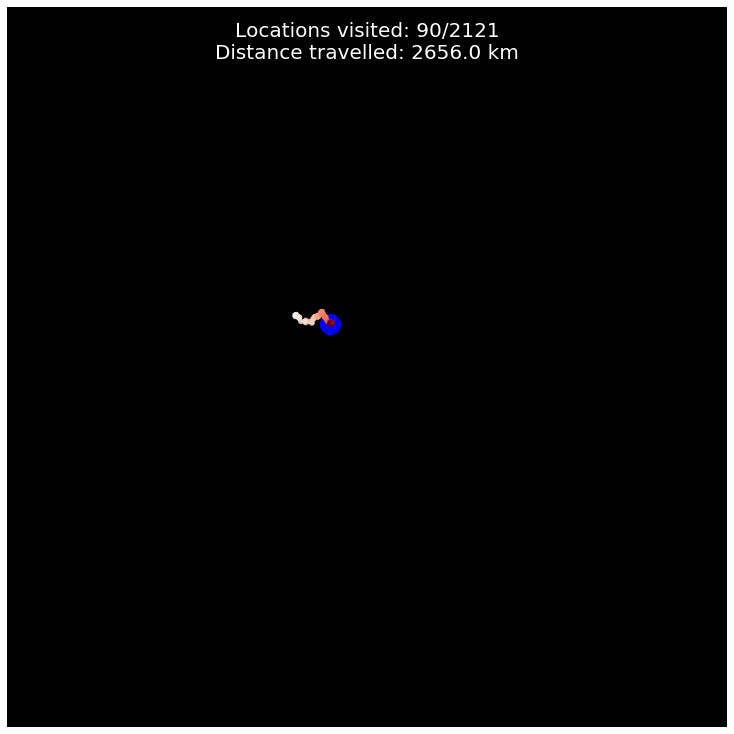

In [10]:
%matplotlib inline
for p in tqdm( range(1,100) ) :
    if p % 10 == 0 :
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        x=np.transpose(Coord_set_3d)[0]
        y=np.transpose(Coord_set_3d)[1]
        z=np.transpose(Coord_set_3d)[2]

        colour=[]
        for k in range(len(x)) :
            colour.append(order[k])

        ax.set_facecolor('black')

        plt.title(f"Locations visited: {p}/{len(Visited_Set)}\nDistance travelled: {round(np.sum(hop_dists[0:p]),0)} km",color='w',fontsize=20)

        ax.scatter(x, y, z, c=colour,marker='o',cmap='Reds',s=20.0,alpha=0.0)
        ax.scatter(x[Visited_Set[0:p]], y[Visited_Set[0:p]], z[Visited_Set[0:p]], c=np.asarray(colour)[Visited_Set[0:p]],marker='o',cmap='Reds',s=20.0,alpha=0.8)
        for edge in tqdm( list(travel_graph.edges() )[0:p] ) :
            x_vals =[ x[edge[0]],x[edge[1]] ]
            y_vals =[ y[edge[0]], y[edge[1]] ]
            z_vals= [ z[edge[0]], z[edge[1]] ]
            ax.plot3D(x_vals,y_vals,z_vals,linewidth=1.0,color='w',alpha=0.8)
            #Adapted from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
            ax.quiver(x[edge[0]], y[edge[0]], z[edge[0]], # <-- starting point of vector
                (x[edge[1]] - x[edge[0]])/2.0, (y[edge[1]] - y[edge[0]])/2.0, (z[edge[1]] - z[edge[0]])/2.0, # <-- directions of vector
                color = 'w', alpha = .8, lw = 1.0)


        ax.scatter([ x[Visited_Set[p]] ], [ y[Visited_Set[p]] ], [ z[Visited_Set[p]] ], c='b',marker='o',s=400.0,alpha=1.0)

        plt.axis('off')
        plt.tight_layout()
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.savefig("Gif_pics/trip_" + str(p).zfill(4),dpi=50)
            
